<a href="https://colab.research.google.com/github/Shi-raishi/Research/blob/main/pattern4_signal_6pt_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ④signalシートのSV  KOMA1～KOMA7<br>
## 主食KOMA1     副菜KOMA2    主菜KOMA3	    乳類KOMA4	   果物KOMA5   	菓子類KOMA6	  酒類KOMA7
主食、副菜、主菜、牛乳・乳製品、果物という5つの料理区分において、「どれだけ食べたらよいか」の目安は「つ（SV）」という単位で示される<br>SV:サービング（料理の量の単位）の略で、食事バランスガイド独自の考え方

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Google Colabにlingamのライブラリをインストールする
!pip install lingam

In [ ]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam.utils import print_causal_directions, print_dagc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.26.2', '1.5.3', '0.20.1', '1.8.2']


##  関数を定義

In [ ]:
# 前処理用（結合、重複削除、NA削除）
def preprocess(df1, df2):
  # df1, df2の重複を確認
  print(f"ID1に重複のある行数\tdf1:{df1['ID1'].duplicated(keep=False).sum()}\tdf2:{df2['ID1'].duplicated(keep=False).sum()}")

  # df2からID1の重複を除去
  df2_cleaned = df2.drop_duplicates(subset='ID1', keep=False)

  # 左結合
  merged_data = pd.merge(df1, df2_cleaned, on='ID1', how='left')

  # 結合後のデータフレームのID1の重複を削除
  merged_data = merged_data.drop_duplicates(subset='ID1',keep=False)# 重複の確認
  print(f"結合後のデータ数:{len(merged_data)}")

  ## エネルギー補正係数とBMIを作成
  # merged_dataのコピーを作成（SettingWithCopyWarningというエラーが出るため）
  merged_data_copy = merged_data.copy()

  # 新しい列を追加(ECF:Energy correction facto(エネルギー補正係数))
  merged_data_copy['BMI'] = merged_data_copy['BW'] / ((merged_data_copy['BH'] / 100) ** 2)

  # 変数を選択
  selected_columns = merged_data_copy.loc[:, 'KOMA1':'KOMA7'].copy()
  selected_columns['BMI'] = merged_data_copy['BMI']
  selected_columns['AGE'] = merged_data_copy['AGE']
  selected_columns['SEX'] = merged_data_copy['SEX']

  # NA処理
  print(f"NAを含むデータ数:{selected_columns[selected_columns.isna().any(axis=1)].shape[0]}")
  selected_columns_cleaned = selected_columns.dropna()
  selected_columns_cleaned.describe()
  display(selected_columns_cleaned.describe())

  print(f"処理後のデータ数:{len(selected_columns_cleaned)}")

  return selected_columns_cleaned

In [ ]:
# 変数同士の相関を確認
def corrMatrix(df):
  # 相関行列の作成
  corr_matrix = df.corr()

  # 高い相関を持つ変数ペアの抽出
  threshold = 0.5  # 閾値を設定
  high_corr_var = [(column, index, corr_matrix[column][index]) for column in corr_matrix.columns for index in corr_matrix.columns if (corr_matrix[column][index] > threshold) & (column != index)]
  for var_pair in high_corr_var:
      print(var_pair)

In [ ]:
# 特定の変数と他の変数との相関を確認
def targetCorrMatrix(df):
  df = 'VEG3'
  correlations = df.corrwith(df[df])
  correlations.sort_values(ascending=False)

In [ ]:
# ヒートマップで相関関係の可視化
def heatMap(df):
  plt.figure(figsize=(15, 15))
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
  plt.show()

In [ ]:
# 個々の変数の分布を確認
def distribution(df):
  for column in df.columns:
      plt.figure()
      sns.histplot(df[column], kde=True)
      plt.title(column)
      plt.show()

In [ ]:
# 変数の0データを確認
def countZeroData(df):
  # 各変数における0の数をカウントし、少ない順にソート
  zero_counts_sorted = (df == 0).sum().sort_values()
  # 各変数における0データ数の表示
  print(zero_counts_sorted)

In [ ]:
# 0データの数をグラフで確認
def countAvairableVariable(df):
  # 0が含まれる数をカウント
  zero_counts = (df == 0).sum().sort_values()

  # グラフのサイズを設定
  plt.figure(figsize=(12, 9))

  # 棒グラフの作成
  sns.barplot(x=len(df)-zero_counts.values, y=zero_counts.index)

  # グラフのタイトルとラベルを設定
  plt.title('Number of non-zero data in each variable')
  plt.xlabel('number of non-zero data')
  plt.ylabel('variable name')

  # グラフの表示
  plt.show()

In [ ]:
def boxplot(df):
  # dfのすべての列に対して箱ひげ図を描画
  plt.figure(figsize=(10, 6))
  sns.boxplot(data=df)
  plt.title("Boxplot of df")
  plt.show()

In [ ]:
# 与えられたデータフレームの変数を見る
def checksVariables(df):
  # non-zeroのデータ数をグラフで確認
  countAvairableVariable(df)
  # 相関行列を確認
  corrMatrix(df)
  # ヒートマップ確認
  heatMap(df)
  # # 各変数の分布を確認
  # distribution(df)
  # 箱ひげ図を描画
  # boxplot(df)

In [ ]:
# 解析に使用するデータフレームを返す
def select_variables(df,columns):
    # 解析に使用する変数のデータフレームを作成
    df = df[columns]

    # 基本統計量の確認
    # print(f"データ数:{len(df)}")
    # display(df.describe())

    # # 各列について、上:0.05%,下:0.05%のデータを外れ値として除去
    # for column in df.columns:
    #     lower_limit = df[column].quantile(0.005)
    #     upper_limit = df[column].quantile(0.995)
    #     df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    # # 修正されたデータフレームを確認
    # print(f"上:0.05%,下:0.05%を除去後のデータ数:{len(df)}")
    # display(df.describe())

    return df

In [ ]:
# 3σ法による外れ値の除去(正規分布)
def remove_outliers_3sigma(df, columns_to_process=None):
    if columns_to_process is None:
        columns_to_process = df.columns
    for column in columns_to_process:
        mean = df[column].mean()
        std = df[column].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        # print(f"{column}:{len(df)}")
    return df

# IQRによる外れ値の除去
def remove_outliers_iqr(df, columns_to_process=None):
    if columns_to_process is None:
        columns_to_process = df.columns
    for column in columns_to_process:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        # print(f"{column}:{len(df)}")
    return df

# # 使い方
# columns_to_process = ['A', 'B']
# df_cleaned_3sigma = remove_outliers_3sigma(df, columns_to_process)
# df_cleaned_iqr = remove_outliers_iqr(df, columns_to_process)

## データ準備

In [ ]:
%cd /content/drive/MyDrive/'Colab Notebooks'
%ls CSV

/content/drive/MyDrive/Colab Notebooks
'BDHQ フォーマット LongDataSet (f_nutr1).csv'
'BDHQ フォーマット LongDataSet (nutr).csv'
'BDHQ フォーマット LongDataSet (signal).csv'
'BDHQ 児童生徒用フォーマット LongDataSet (food2).csv'
'BDHQ 成人用フォーマット LongDataSet (food).csv'
 Shift-JISに変換したもの/


In [ ]:
# CSVの読み込み
data_nutr = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (nutr).csv')
data_signal = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (signal).csv')

In [ ]:
print(len(data_signal),len(data_nutr))

3346 3329


In [ ]:
# 前処理（結合、重複削除、NA削除）
preprocessed_df = preprocess(data_signal,data_nutr)

ID1に重複のある行数	df1:134	df2:116
結合後のデータ数:3212
NAを含むデータ数:10


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI,AGE,SEX
count,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000
mean,4.294365,5.256992,7.960230,1.784571,0.850683,2.962818,0.852380,22.313184,47.709869,1.605871
std,1.663748,2.707049,3.087344,1.641892,0.763708,1.942048,1.818285,3.648765,22.889227,0.488739
min,0.280320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.326516,10.000000,1.000000
25%,3.085925,3.411741,5.792025,0.514033,0.279521,1.541204,0.000000,19.735976,25.000000,1.000000
50%,4.109877,4.813307,7.564622,1.523493,0.647342,2.659966,0.000000,21.958811,53.000000,2.000000
75%,5.284650,6.627483,9.700675,2.504225,1.210074,3.961218,0.661117,24.444444,67.000000,2.000000
max,12.194364,21.371829,22.938361,16.459607,5.809695,13.377456,16.022896,50.781250,96.000000,2.000000


処理後のデータ数:3202


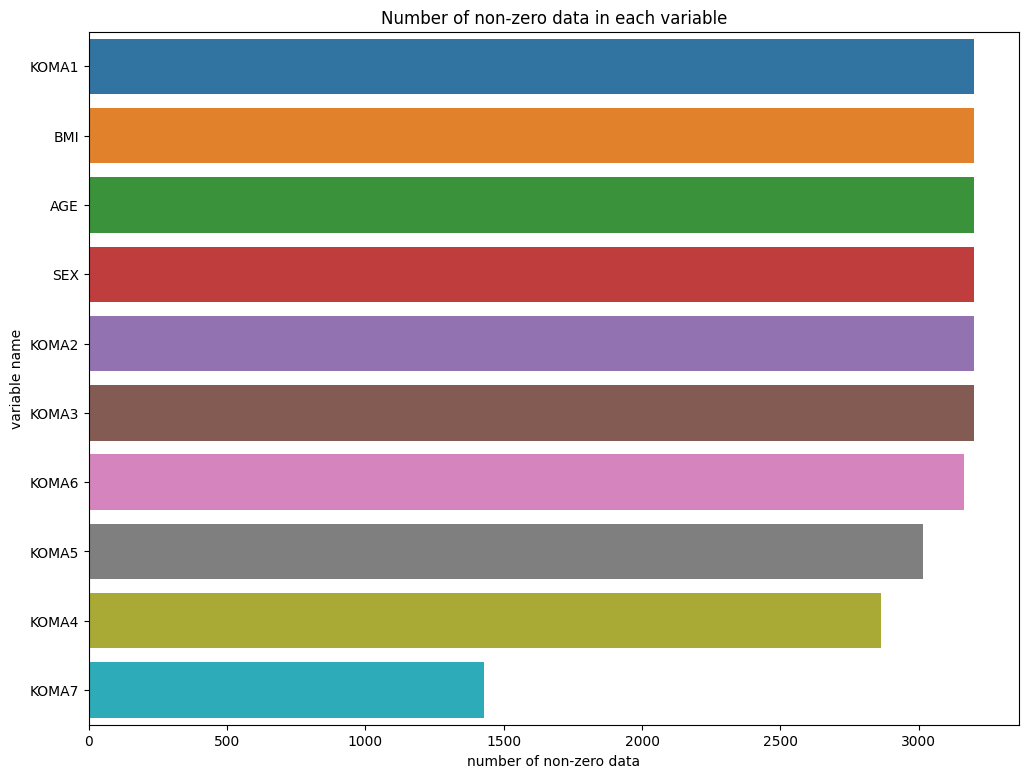

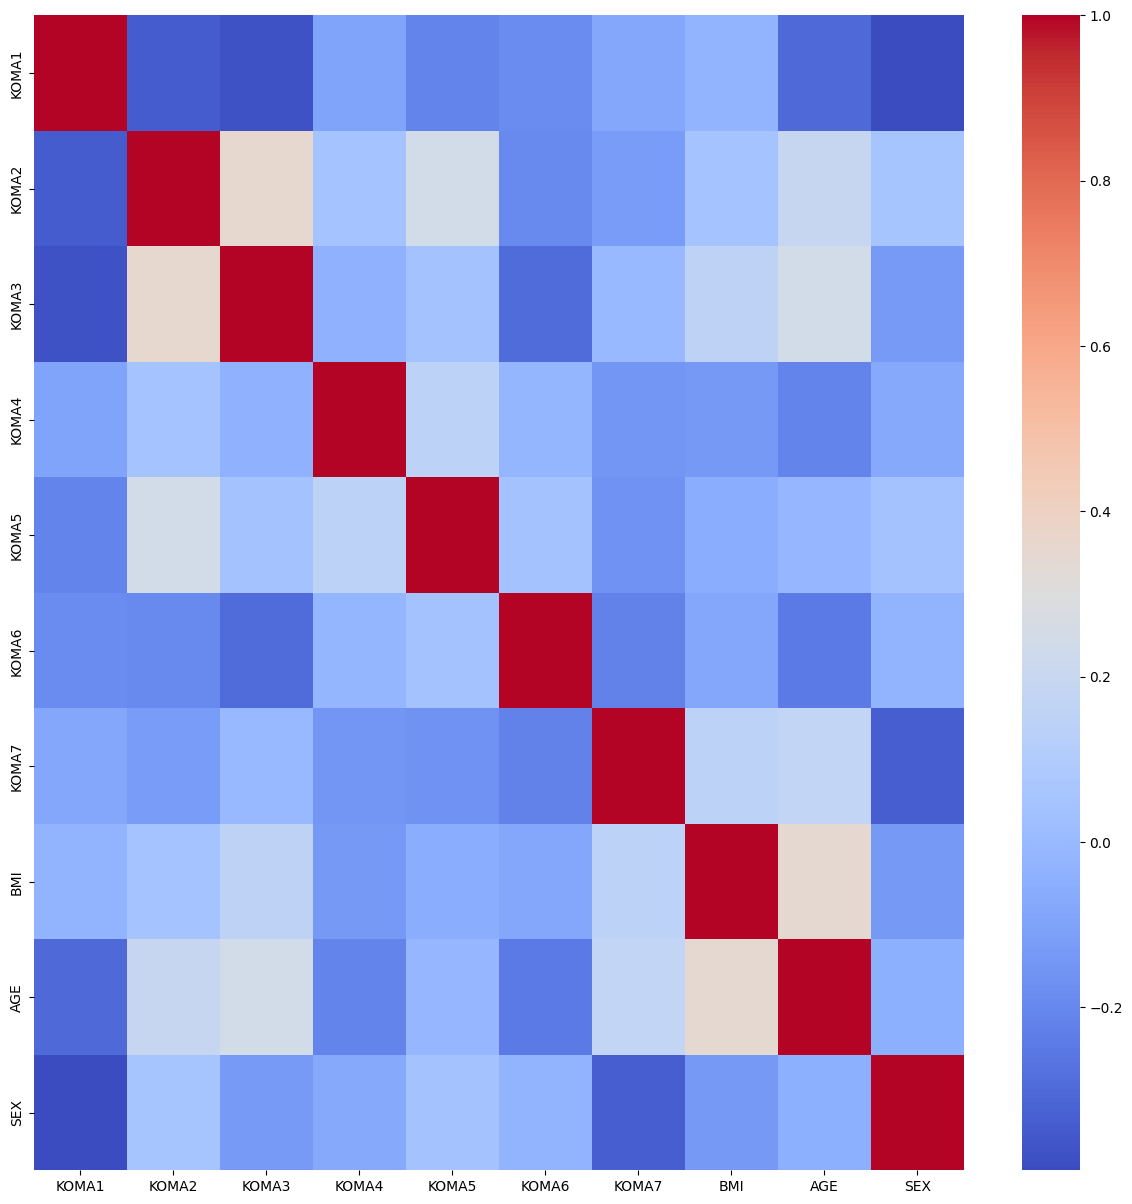

In [ ]:
# 変数の相関を確認
checksVariables(preprocessed_df)

In [ ]:
# 使用する変数を選択
columns_for_lingam = ['KOMA1', 'KOMA2', 'KOMA3', 'KOMA4', 'KOMA5', 'KOMA6', 'KOMA7','BMI','SEX','AGE']
variables_df = preprocessed_df[columns_for_lingam]
len(variables_df)

3202

In [ ]:
# 外れ値の除去、ecfは扱っていない
def outliers_process(df):
  # (AGE,SEXを除く変数)
  columns_to_process = df.columns.to_list()
  columns_to_process.remove('AGE')

  # 箱ヒゲ
  # boxplot(df[columns_to_process])

  # # 各変数の変動係数
  # coeff_of_variation = df[columns_to_process].std() / df[columns_to_process].mean() * 100
  # print(coeff_of_variation)

  # # IQRによる外れ値の除去
  df_cleaned_iqr = remove_outliers_iqr(df,columns_to_process)

  # データフレームから少なくとも1つの変数に0データを含む行を除去
  # df = df[(df != 0).all(axis=1)]

  return df_cleaned_iqr[columns_to_process]

In [ ]:
# 外れ値の除去、ecfは扱っていない,0データを除去
def outliers_process_drop_0data(df):
  # (AGE,SEXを除く変数)
  columns_to_process = df.columns.to_list()
  columns_to_process.remove('AGE')

  # 箱ヒゲ
  # boxplot(df[columns_to_process])

  # # 各変数の変動係数
  # coeff_of_variation = df[columns_to_process].std() / df[columns_to_process].mean() * 100
  # print(coeff_of_variation)

  # # IQRによる外れ値の除去
  df_cleaned_iqr = remove_outliers_iqr(df,columns_to_process)

  # データフレームから、少なくとも1つの変数に0データを含む行を除去
  df_cleaned_iqr = df_cleaned_iqr[(df_cleaned_iqr != 0).all(axis=1)]

  return df_cleaned_iqr[columns_to_process]

In [ ]:
# signal_data_list <- 全体データ、全データ(drop_0data)、男性群、男性群(drop_0data)、女性群、女性群(drop_0data)
signal_data_list = []
signal_data_list.append(outliers_process(variables_df.drop(['SEX'], axis=1)))
signal_data_list.append(outliers_process_drop_0data(variables_df.drop(['SEX'], axis=1)))

signal_data_list.append(outliers_process(variables_df[variables_df['SEX'] == 1].drop('SEX', axis=1)))
signal_data_list.append(outliers_process_drop_0data(variables_df[variables_df['SEX'] == 1].drop('SEX', axis=1)))

signal_data_list.append(outliers_process(variables_df[variables_df['SEX'] == 2].drop('SEX', axis=1)))
signal_data_list.append(outliers_process_drop_0data(variables_df[variables_df['SEX'] == 2].drop('SEX', axis=1)))

In [ ]:
for x in signal_data_list:
  display(x.describe())
  print(len(x))

,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI
count,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000
mean,4.326501,5.166207,7.835968,1.675521,0.821277,3.050386,0.192716,21.914774
std,1.505267,2.154771,2.635430,1.252891,0.602521,1.673867,0.408060,3.259700
min,0.785442,0.595183,0.893699,0.000000,0.000000,0.000000,0.000000,13.200184
25%,3.217650,3.569948,5.903901,0.643910,0.325914,1.808684,0.000000,19.531250
50%,4.166067,4.869477,7.596189,1.554752,0.704780,2.870482,0.000000,21.688889
75%,5.327331,6.552914,9.596561,2.430260,1.195105,4.084838,0.130562,24.093118
max,8.548474,11.430752,15.395133,5.363274,2.543613,7.732492,1.895115,31.245237


2211


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI
count,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000
mean,4.043001,5.394446,8.247047,1.667955,0.822152,2.903798,0.518850,22.652646
std,1.418022,2.003671,2.508343,1.090071,0.571553,1.560779,0.524270,2.863595
min,0.785442,1.287616,1.505786,0.096455,0.044795,0.181904,0.005783,14.951514
25%,3.038262,3.893559,6.453871,0.825258,0.369104,1.764880,0.090320,20.569330
50%,3.888649,5.248875,8.060476,1.549560,0.702578,2.700990,0.313541,22.384553
75%,4.891745,6.572959,9.735766,2.257156,1.151500,3.694160,0.803313,24.506490
max,8.548474,11.430752,15.331490,5.363274,2.540527,7.721103,1.889683,30.959486


717


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI
count,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000
mean,5.255148,4.800836,8.330734,1.726771,0.706464,2.991907,1.560919,22.833110
std,1.575817,2.230250,2.884116,1.488694,0.580769,1.836428,2.068347,3.495045
min,1.404272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.473917
25%,4.179920,3.237316,6.316527,0.352340,0.233999,1.542825,0.000000,20.334154
50%,5.135105,4.521631,8.102946,1.532289,0.548095,2.764306,0.393869,22.865854
75%,6.249270,6.214710,10.255513,2.616822,1.109776,4.097706,2.798370,25.212725
max,9.410388,11.179820,16.483345,6.300565,2.505070,8.239451,7.695571,32.421875


1015


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI
count,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000
mean,4.901951,5.010068,8.650798,1.736603,0.725210,2.740700,2.378285,23.672070
std,1.440348,2.176205,2.656861,1.281943,0.536748,1.734356,2.034770,2.957375
min,1.549933,0.166239,1.786961,0.112664,0.054627,0.123076,0.012322,13.473917
25%,3.956869,3.440967,6.818937,0.652096,0.290788,1.400298,0.634622,21.769348
50%,4.774032,4.855458,8.481494,1.563791,0.572333,2.372849,1.843061,23.529412
75%,5.883069,6.270632,10.303771,2.485057,1.071145,3.672406,3.864883,25.651757
max,9.135888,11.104265,16.483345,6.300565,2.460417,8.239451,7.695571,32.421875


475


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,3.911565,5.246319,7.581917,1.568491,0.836533,2.965929,0.035096,21.674833
std,1.255550,2.157557,2.512802,1.116038,0.607707,1.603248,0.082648,3.109673
min,0.785442,0.595183,0.893699,0.000000,0.000000,0.000000,0.000000,13.200184
25%,3.009146,3.613172,5.755615,0.655939,0.342778,1.774774,0.000000,19.453282
50%,3.796500,4.921800,7.283863,1.488163,0.719505,2.802272,0.000000,21.359306
75%,4.719554,6.671830,9.288545,2.200582,1.203518,3.951901,0.007224,23.662814
max,7.132819,11.366708,14.656891,4.724041,2.593863,7.309288,0.396166,30.427198


1338


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI
count,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000
mean,3.545858,5.468224,7.939722,1.566786,0.816768,2.902271,0.136791,22.340993
std,1.039961,1.971732,2.337192,0.999460,0.560749,1.491097,0.110245,2.794265
min,0.785442,1.354155,2.670125,0.108799,0.044795,0.261894,0.005783,14.951514
25%,2.835787,3.928881,6.364088,0.801638,0.397138,1.811706,0.040220,20.367695
50%,3.505363,5.311783,7.854005,1.458202,0.690489,2.749503,0.098382,22.070312
75%,4.273865,6.674022,9.470530,2.078297,1.106127,3.657501,0.209200,24.199178
max,6.628780,11.330958,14.634376,4.696685,2.540527,7.296975,0.396166,30.154932


315


### LiNGAMの関数定義

In [ ]:
def model_DirectLiNGAM(df,dagname):
  # 標準化
  scaler = StandardScaler()
  Xy = scaler.fit_transform(df)

  # モデル作成
  model = lingam.DirectLiNGAM(random_state=1)
  model.fit(Xy)

  # 因果順序
  print(f"因果の順番\n{model.causal_order_}\n\n_________")

  # 隣接行列
  print("隣接行列\n")
  display(model.adjacency_matrix_)
  print("\n")

  # 因果グラフ
  dot = make_dot(
      model.adjacency_matrix_,
      labels = df.columns.to_list(),
      lower_limit = 0.01)
  display(dot)
  dot.format = 'png'
  dot.render(dagname)

  # 推定した因果モデルにおける、誤差同士の独立性のp値
  p_values = model.get_error_independence_p_values(Xy)
  display(p_values)

  return model

In [ ]:
def model_MultiDirectLiNGAM(df_list):
  # 標準化
  scaler = StandardScaler()
  Xy_list = []
  for df in df_list:
    Xy_list.append(scaler.fit_transform(df))

  # モデル作成
  model = lingam.MultiGroupDirectLiNGAM(random_state=1)
  model.fit(Xy_list)

  for index in range(len(Xy_list)):
    # 因果順序
    print(f"因果順序\n{model.causal_order_}\n\n")

    # 隣接行列
    print(f"隣接行列")
    display(model.adjacency_matrices_[index])
    print("\n")

    # 因果グラフの表示と保存
    dot = make_dot(model.adjacency_matrices_[index],
            labels = df_list[index].columns.to_list(),
            lower_limit = 0.01)
    display(dot)
    dot.format = 'png'
    dagname = f"signal_Direct{index}"
    dot.render(dagname)

    # 因果モデルにおける誤差同士の独立性のp値
    p_values = model.get_error_independence_p_values(df_list)
    display(p_values[index])

  # return model

In [ ]:
def model_bootstrap(df, n_sampling):
    scaler = StandardScaler()
    Xy = scaler.fit_transform(df)

    model = lingam.DirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy, n_sampling=n_sampling)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
    cdc = result.get_causal_direction_counts(n_directions=10, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_causal_directions(cdc, n_sampling, labels=df.columns.to_list())

    # カウント結果を確率として、隣接行列の形式で表示
    prob = result.get_probabilities(min_causal_effect=0.01)
    print(prob)

    # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
    dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_dagc(dagc, n_sampling, labels=df.columns.to_list())

    # Total Causal Effects
    causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

    # Assign to pandas.DataFrame for pretty display
    df_ = pd.DataFrame(causal_effects)
    labels = df.columns.to_list()
    # 'from' 列と 'to' 列のラベルを適用する
    df_['from'] = df_['from'].apply(lambda x: labels[x])
    df_['to'] = df_['to'].apply(lambda x: labels[x])
    return df_

In [ ]:
def model_MultiBootstrap(df_list, n_sampling):
    # 標準化
    scaler = StandardScaler()
    Xy_list = []
    for df in df_list:
      Xy_list.append(scaler.fit_transform(df))

    # モデル作成
    model = lingam.MultiGroupDirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy_list, n_sampling=n_sampling)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # 各グループの結果を表示
    for idx in range(len(Xy_list)):
      print(f"\n\n=============================================signal_bootstrap_{idx}=============================================")
      # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
      cdc = result[idx].get_causal_direction_counts(n_directions=10, min_causal_effect=0.01, split_by_causal_effect_sign=True)
      print("因果方法top10")
      print_causal_directions(cdc, n_sampling, labels=df.columns.to_list())
      print()

      # カウント結果を確率として、隣接行列の形式で表示(表として表示したいがうまくいかないのでそのまま)
      prob = result[idx].get_probabilities(min_causal_effect=0.01)
      colsname = df_list[idx].columns.tolist()
      prob = pd.DataFrame(prob, columns=colsname, index=colsname)
      print("カウント確率")
      display(prob)
      print()

      # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
      dagc = result[idx].get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
      print("DAGのカウント結果")
      print_dagc(dagc, n_sampling, labels=df.columns.to_list())
      print()

      # Total Causal Effects
      causal_effects = result[idx].get_total_causal_effects(min_causal_effect=0.01)

      # Assign to pandas.DataFrame for pretty display
      df_ = pd.DataFrame(causal_effects)
      labels = df_list[idx].columns.to_list()
      # 'from' 列と 'to' 列のラベルを適用する
      df_['from'] = df_['from'].apply(lambda x: labels[x])
      df_['to'] = df_['to'].apply(lambda x: labels[x])
      display(df_)


因果順序
[6, 4, 5, 2, 1, 7, 3, 0]


隣接行列


array([[ 0.        , -0.25658731, -0.34797446, -0.12435785, -0.14553132,
        -0.3534439 ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.27993873,  0.        ,  0.21544784,
        -0.13863679,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.0628165 ,
        -0.30590106,  0.07555598,  0.        ],
       [ 0.        ,  0.        , -0.05948974,  0.        ,  0.16283384,
        -0.07945328,  0.        , -0.07658959],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.08721225,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.19067922,  0.        ,  0.        ,
         0.        ,  0.07714225,  0.        ]])

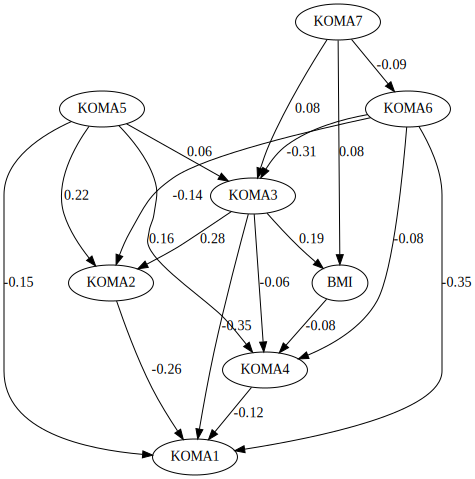

array([[0.00000000e+00, 1.78375940e-10, 4.85486251e-43, 7.29349846e-11,
        1.65837473e-01, 2.55791614e-12, 6.93167903e-09, 6.10358330e-03],
       [1.78375940e-10, 0.00000000e+00, 3.39697810e-04, 2.86735669e-05,
        1.18496477e-22, 1.56341156e-04, 6.08464520e-01, 2.87926963e-04],
       [4.85486251e-43, 3.39697810e-04, 0.00000000e+00, 1.33811637e-09,
        3.20552516e-03, 3.26272135e-08, 4.18483804e-06, 1.05110314e-02],
       [7.29349846e-11, 2.86735669e-05, 1.33811637e-09, 0.00000000e+00,
        1.15607073e-19, 1.25198334e-01, 5.57498803e-01, 3.21699293e-14],
       [1.65837473e-01, 1.18496477e-22, 3.20552516e-03, 1.15607073e-19,
        0.00000000e+00, 5.04462097e-02, 1.06494243e-01, 1.16213678e-01],
       [2.55791614e-12, 1.56341156e-04, 3.26272135e-08, 1.25198334e-01,
        5.04462097e-02, 0.00000000e+00, 6.59742721e-03, 8.45014387e-02],
       [6.93167903e-09, 6.08464520e-01, 4.18483804e-06, 5.57498803e-01,
        1.06494243e-01, 6.59742721e-03, 0.00000000e+00, 1.

因果順序
[6, 4, 5, 2, 1, 7, 3, 0]


隣接行列


array([[ 0.        , -0.25152405, -0.3141714 , -0.11101631, -0.1448755 ,
        -0.33145746,  0.        ,  0.09324952],
       [ 0.        ,  0.        ,  0.20634695,  0.        ,  0.22980511,
        -0.13358008,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.29916897,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.11715009,
        -0.11626668,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.10798467,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

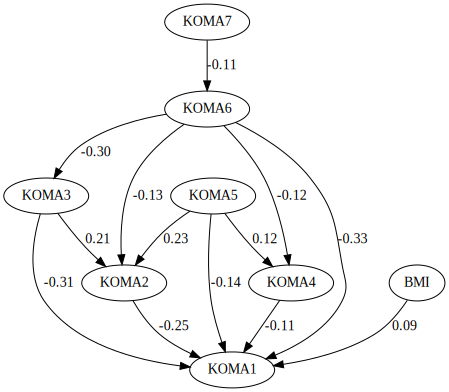

array([[0.00000000e+00, 1.24881633e-01, 2.55969982e-13, 3.51511256e-03,
        5.35093391e-01, 4.01351383e-04, 3.47713312e-04, 1.61273212e-05],
       [1.24881633e-01, 0.00000000e+00, 2.30683834e-01, 1.61783573e-02,
        1.20752309e-06, 1.61940039e-01, 6.70692061e-01, 4.08292813e-01],
       [2.55969982e-13, 2.30683834e-01, 0.00000000e+00, 9.56324390e-01,
        4.25213986e-02, 6.05231108e-03, 5.57177832e-01, 2.71434169e-01],
       [3.51511256e-03, 1.61783573e-02, 9.56324390e-01, 0.00000000e+00,
        2.94590249e-06, 3.80139812e-01, 1.20978050e-01, 1.43047862e-02],
       [5.35093391e-01, 1.20752309e-06, 4.25213986e-02, 2.94590249e-06,
        0.00000000e+00, 8.77069764e-01, 2.26117543e-01, 4.47716689e-01],
       [4.01351383e-04, 1.61940039e-01, 6.05231108e-03, 3.80139812e-01,
        8.77069764e-01, 0.00000000e+00, 2.37788362e-01, 5.48991309e-01],
       [3.47713312e-04, 6.70692061e-01, 5.57177832e-01, 1.20978050e-01,
        2.26117543e-01, 2.37788362e-01, 0.00000000e+00, 3.

因果順序
[6, 4, 5, 2, 1, 7, 3, 0]


隣接行列


array([[ 0.        , -0.23985443, -0.46611404, -0.28656023, -0.14353229,
        -0.54413283, -0.59612482,  0.        ],
       [ 0.        ,  0.        ,  0.33773321,  0.        ,  0.26717253,
        -0.08739938, -0.1039651 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.12050141,
        -0.23154565, -0.07613617,  0.        ],
       [ 0.        ,  0.        , -0.07862477,  0.        ,  0.17679055,
        -0.10253763, -0.19673193, -0.13491901],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.24514539,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.09415036,
         0.        , -0.31834209,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.19120186,  0.        , -0.07476057,
         0.        ,  0.1964188 ,  0.        ]])

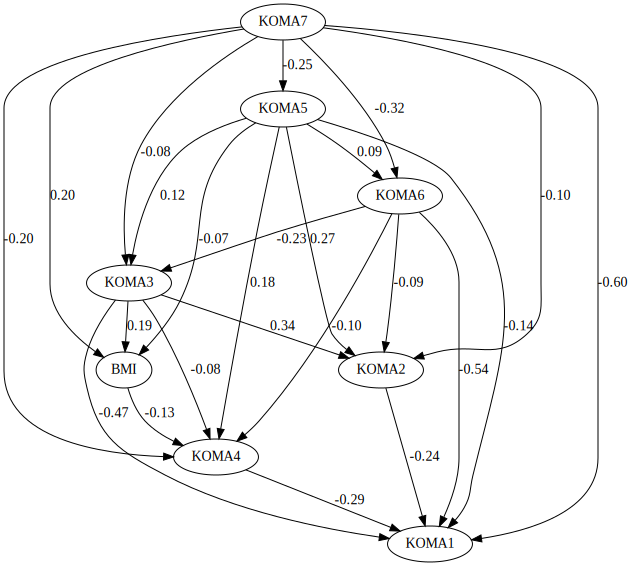

array([[0.00000000e+00, 1.39323148e-03, 5.29465475e-69, 1.21966185e-01,
        7.86476701e-02, 1.42826967e-01, 1.77338775e-15, 2.62103670e-10],
       [1.39323148e-03, 0.00000000e+00, 2.20558562e-08, 1.43401179e-01,
        3.09370708e-03, 2.38886766e-02, 6.83777030e-02, 3.42491344e-01],
       [5.29465475e-69, 2.20558562e-08, 0.00000000e+00, 3.56543166e-02,
        3.22116249e-02, 3.20259077e-03, 3.83898690e-02, 9.62765483e-04],
       [1.21966185e-01, 1.43401179e-01, 3.56543166e-02, 0.00000000e+00,
        4.83721418e-10, 2.42873931e-01, 1.26765261e-03, 1.15318506e-08],
       [7.86476701e-02, 3.09370708e-03, 3.22116249e-02, 4.83721418e-10,
        0.00000000e+00, 1.78373513e-08, 7.62675318e-91, 3.98131559e-04],
       [1.42826967e-01, 2.38886766e-02, 3.20259077e-03, 2.42873931e-01,
        1.78373513e-08, 0.00000000e+00, 2.80712209e-13, 5.41663984e-01],
       [1.77338775e-15, 6.83777030e-02, 3.83898690e-02, 1.26765261e-03,
        7.62675318e-91, 2.80712209e-13, 0.00000000e+00, 3.

因果順序
[6, 4, 5, 2, 1, 7, 3, 0]


隣接行列


array([[ 0.        , -0.2701943 , -0.5534818 , -0.25896389, -0.16312581,
        -0.5414942 , -0.65704167,  0.        ],
       [ 0.        ,  0.        ,  0.27678262,  0.        ,  0.21005133,
        -0.14571066, -0.15615898,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.1579186 ,
        -0.27649123, -0.18609961,  0.        ],
       [ 0.        ,  0.09686107, -0.10857184,  0.        ,  0.12824256,
        -0.14801496, -0.15672082,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.18021222,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.31910497,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

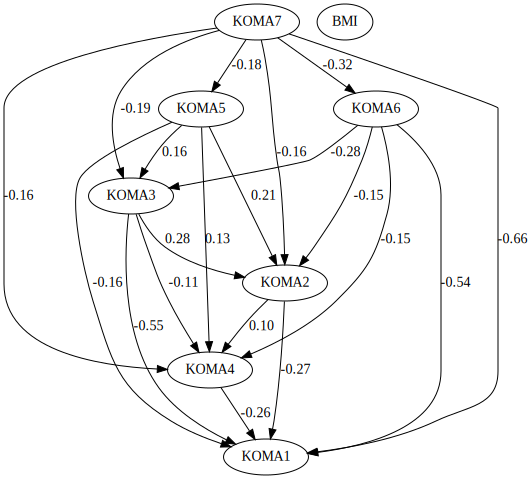

array([[0.00000000e+00, 2.43503651e-04, 3.88339087e-45, 3.24557769e-01,
        5.54108428e-01, 5.71254204e-01, 6.75735272e-06, 5.73040977e-01],
       [2.43503651e-04, 0.00000000e+00, 9.10121313e-03, 2.46878524e-01,
        3.54737300e-02, 7.75834753e-02, 2.53454289e-01, 7.67488240e-01],
       [3.88339087e-45, 9.10121313e-03, 0.00000000e+00, 6.42306169e-02,
        3.27479186e-01, 7.99618169e-02, 7.38624208e-01, 6.97278871e-01],
       [3.24557769e-01, 2.46878524e-01, 6.42306169e-02, 0.00000000e+00,
        1.33546599e-04, 5.79978684e-01, 7.38951405e-01, 1.65816968e-01],
       [5.54108428e-01, 3.54737300e-02, 3.27479186e-01, 1.33546599e-04,
        0.00000000e+00, 1.30617630e-02, 1.06465555e-40, 8.74996612e-01],
       [5.71254204e-01, 7.75834753e-02, 7.99618169e-02, 5.79978684e-01,
        1.30617630e-02, 0.00000000e+00, 7.37667214e-08, 1.56529381e-01],
       [6.75735272e-06, 2.53454289e-01, 7.38624208e-01, 7.38951405e-01,
        1.06465555e-40, 7.37667214e-08, 0.00000000e+00, 1.

因果順序
[6, 4, 5, 2, 1, 7, 3, 0]


隣接行列


array([[ 0.        , -0.23732324, -0.59481978, -0.20852921, -0.13737409,
        -0.52012359, -0.085075  , -0.11368092],
       [ 0.        ,  0.        ,  0.26369555,  0.        ,  0.18250059,
        -0.14583018,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.36257533,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.15591361,
        -0.07298015,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.10247177,  0.12633155,  0.        ,  0.        ,
         0.        ,  0.0713183 ,  0.        ]])

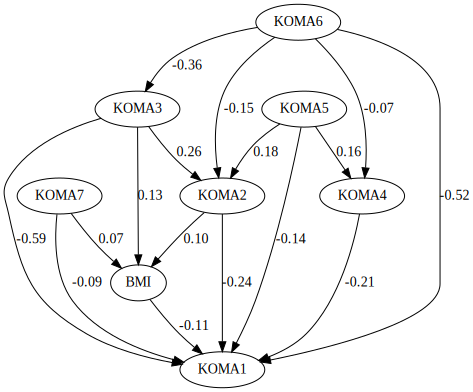

array([[0.00000000e+000, 6.75621038e-009, 2.37818115e-168,
        7.62035376e-005, 7.66898410e-001, 8.95599925e-004,
        5.89110879e-004, 8.57431975e-008],
       [6.75621038e-009, 0.00000000e+000, 2.64842828e-003,
        2.52959818e-002, 2.52494204e-010, 1.47601255e-003,
        1.26396466e-001, 3.65525214e-003],
       [2.37818115e-168, 2.64842828e-003, 0.00000000e+000,
        1.40744341e-005, 1.24155533e-002, 1.90999243e-006,
        3.86331338e-002, 4.27051533e-002],
       [7.62035376e-005, 2.52959818e-002, 1.40744341e-005,
        0.00000000e+000, 5.29741193e-009, 4.44751177e-001,
        6.54545520e-003, 9.53851236e-002],
       [7.66898410e-001, 2.52494204e-010, 1.24155533e-002,
        5.29741193e-009, 0.00000000e+000, 2.92672489e-001,
        4.15617692e-004, 5.92714421e-001],
       [8.95599925e-004, 1.47601255e-003, 1.90999243e-006,
        4.44751177e-001, 2.92672489e-001, 0.00000000e+000,
        1.32523074e-001, 2.36058775e-001],
       [5.89110879e-004, 1.2639646

因果順序
[6, 4, 5, 2, 1, 7, 3, 0]


隣接行列


array([[ 0.        , -0.23288471, -0.65055799, -0.25969711, -0.14808657,
        -0.6754444 ,  0.        , -0.07166845],
       [ 0.        ,  0.        ,  0.14176825,  0.        ,  0.26068392,
        -0.12886499,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.33160622,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.19122872,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

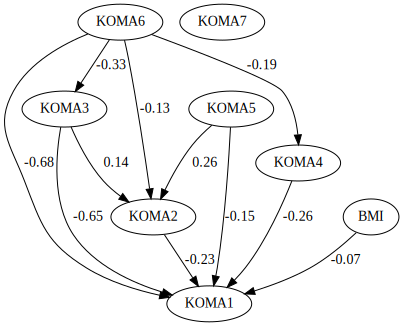

array([[0.00000000e+00, 1.39138923e-02, 1.08182950e-60, 8.29609987e-01,
        9.48146940e-01, 2.44618513e-01, 8.84934723e-01, 2.55606112e-03],
       [1.39138923e-02, 0.00000000e+00, 2.01733893e-02, 3.43156680e-01,
        4.60321942e-02, 6.98064696e-01, 2.22333912e-03, 3.33286371e-03],
       [1.08182950e-60, 2.01733893e-02, 0.00000000e+00, 7.41343003e-01,
        4.93150254e-01, 5.84005486e-02, 4.06203184e-01, 3.40558466e-01],
       [8.29609987e-01, 3.43156680e-01, 7.41343003e-01, 0.00000000e+00,
        1.00385763e-05, 3.32054921e-01, 9.03025310e-02, 7.67647963e-01],
       [9.48146940e-01, 4.60321942e-02, 4.93150254e-01, 1.00385763e-05,
        0.00000000e+00, 6.40570380e-01, 2.69218238e-03, 1.97932474e-01],
       [2.44618513e-01, 6.98064696e-01, 5.84005486e-02, 3.32054921e-01,
        6.40570380e-01, 0.00000000e+00, 1.24084438e-01, 9.70887581e-01],
       [8.84934723e-01, 2.22333912e-03, 4.06203184e-01, 9.03025310e-02,
        2.69218238e-03, 1.24084438e-01, 0.00000000e+00, 1.

In [ ]:
# # マルチリンガム
model = model_MultiDirectLiNGAM(signal_data_list)

In [ ]:
# ブートストラップ法：引数（データフレームリスト, サンプル回数）
pretty_causal_effects = model_MultiBootstrap(signal_data_list, 1000)
display(pretty_causal_effects)



=============================================signal_bootstrap_0=============================================
因果方法top10
KOMA1 <--- KOMA3 (b<0) (100.0%)
KOMA1 <--- KOMA5 (b<0) (100.0%)
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA4 <--- KOMA5 (b>0) (100.0%)
KOMA2 <--- KOMA5 (b>0) (100.0%)
KOMA1 <--- KOMA2 (b<0) (99.9%)
KOMA3 <--- KOMA6 (b<0) (97.4%)
KOMA6 <--- KOMA7 (b<0) (91.0%)
BMI <--- KOMA7 (b>0) (90.5%)
KOMA2 <--- KOMA6 (b<0) (89.0%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI
KOMA1,0.000,0.999,1.000,0.876,1.000,1.000,0.221,0.018
KOMA2,0.001,0.000,0.726,0.006,1.000,0.890,0.025,0.345
KOMA3,0.000,0.274,0.000,0.097,0.544,0.974,0.733,0.632
KOMA4,0.124,0.067,0.516,0.000,1.000,0.718,0.219,0.743
KOMA5,0.000,0.000,0.000,0.000,0.000,0.000,0.139,0.000
KOMA6,0.000,0.110,0.026,0.030,0.120,0.000,0.910,0.170
KOMA7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
BMI,0.004,0.234,0.368,0.134,0.196,0.296,0.905,0.000



DAGのカウント結果
DAG[0]: 0.7%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA7 (b>0)
	KOMA3 <--- BMI (b>0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	KOMA4 <--- BMI (b<0)
	KOMA6 <--- KOMA7 (b<0)
	KOMA6 <--- BMI (b<0)
	BMI <--- KOMA7 (b>0)
DAG[1]: 0.6%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA2 <--- BMI (b>0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA7 (b>0)
	KOMA3 <--- BMI (b>0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	KOMA4 <--- BMI (b<0)
	KOMA6 <--- KOMA7 (b<0)
	BMI <--- KOMA6 (b<0)
	BMI <--- KOMA7 (b>0)
DAG[2]: 0.5%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 

,from,to,effect,probability
0,KOMA3,KOMA1,-0.404271,1.000
1,KOMA5,KOMA4,0.159097,1.000
2,KOMA5,KOMA1,-0.249688,1.000
3,KOMA6,KOMA1,-0.189110,1.000
4,KOMA5,KOMA2,0.228359,1.000
5,KOMA2,KOMA1,-0.264975,0.999
6,KOMA7,KOMA3,0.101784,0.980
7,KOMA7,BMI,0.097179,0.978
8,KOMA6,KOMA3,-0.301954,0.974
9,KOMA7,KOMA6,-0.089400,0.931




=============================================signal_bootstrap_1=============================================
因果方法top10
KOMA1 <--- KOMA3 (b<0) (100.0%)
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA2 <--- KOMA5 (b>0) (100.0%)
KOMA1 <--- KOMA2 (b<0) (99.9%)
KOMA1 <--- KOMA5 (b<0) (99.4%)
KOMA3 <--- KOMA6 (b<0) (97.4%)
KOMA2 <--- KOMA6 (b<0) (83.4%)
KOMA1 <--- KOMA4 (b<0) (77.4%)
KOMA2 <--- KOMA3 (b>0) (72.3%)
KOMA4 <--- KOMA6 (b<0) (67.9%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI
KOMA1,0.000,0.999,1.000,0.774,0.994,1.000,0.209,0.659
KOMA2,0.001,0.000,0.723,0.024,1.000,0.834,0.027,0.037
KOMA3,0.000,0.272,0.000,0.015,0.210,0.974,0.042,0.349
KOMA4,0.100,0.191,0.098,0.000,0.678,0.679,0.283,0.080
KOMA5,0.000,0.000,0.000,0.000,0.000,0.002,0.013,0.001
KOMA6,0.000,0.109,0.026,0.034,0.043,0.000,0.641,0.044
KOMA7,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000
BMI,0.060,0.022,0.169,0.018,0.102,0.123,0.068,0.000



DAGのカウント結果
DAG[0]: 1.0%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- BMI (b>0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	KOMA6 <--- KOMA7 (b<0)
DAG[1]: 0.7%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- BMI (b>0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
DAG[2]: 0.7%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	KOMA6 <--- KOMA7 (b<0)



,from,to,effect,probability
0,KOMA3,KOMA1,-0.347222,1.000
1,KOMA5,KOMA1,-0.243388,1.000
2,KOMA5,KOMA2,0.242876,1.000
3,KOMA2,KOMA1,-0.265148,0.999
4,KOMA6,KOMA1,-0.180431,0.985
5,KOMA6,KOMA3,-0.298130,0.974
6,KOMA6,KOMA2,-0.194131,0.887
7,KOMA5,KOMA4,0.132276,0.743
8,KOMA3,KOMA2,0.221145,0.724
9,KOMA7,KOMA6,-0.124381,0.649




=============================================signal_bootstrap_2=============================================
因果方法top10
BMI <--- KOMA7 (b>0) (100.0%)
KOMA1 <--- KOMA3 (b<0) (100.0%)
KOMA6 <--- KOMA7 (b<0) (100.0%)
KOMA1 <--- KOMA5 (b<0) (100.0%)
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA1 <--- KOMA7 (b<0) (100.0%)
KOMA4 <--- KOMA7 (b<0) (100.0%)
KOMA2 <--- KOMA5 (b>0) (100.0%)
KOMA5 <--- KOMA7 (b<0) (99.9%)
KOMA1 <--- KOMA2 (b<0) (99.9%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI
KOMA1,0.000,0.999,1.000,0.876,1.000,1.000,1.000,0.163
KOMA2,0.001,0.000,0.726,0.012,1.000,0.602,0.769,0.090
KOMA3,0.000,0.274,0.000,0.091,0.710,0.974,0.611,0.631
KOMA4,0.124,0.174,0.584,0.000,0.917,0.690,1.000,0.835
KOMA5,0.000,0.000,0.000,0.000,0.000,0.022,0.999,0.002
KOMA6,0.000,0.108,0.026,0.029,0.710,0.000,1.000,0.018
KOMA7,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000
BMI,0.014,0.043,0.368,0.149,0.312,0.036,1.000,0.000



DAGのカウント結果
DAG[0]: 3.3%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA7 (b<0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA7 (b<0)
	KOMA3 <--- BMI (b>0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA7 (b<0)
	KOMA4 <--- BMI (b<0)
	KOMA5 <--- KOMA7 (b<0)
	KOMA6 <--- KOMA5 (b>0)
	KOMA6 <--- KOMA7 (b<0)
	BMI <--- KOMA7 (b>0)
DAG[1]: 1.4%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA7 (b<0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA7 (b<0)
	KOMA3 <--- BMI (b>0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA7 (b<0)
	KOMA4 <--- BMI (b<0)
	KOMA5 <--- 

,from,to,effect,probability
0,KOMA7,BMI,0.208434,1.000
1,KOMA3,KOMA1,-0.504027,1.000
2,KOMA7,KOMA6,-0.342182,1.000
3,KOMA5,KOMA1,-0.358127,1.000
4,KOMA6,KOMA1,-0.383154,1.000
5,KOMA7,KOMA1,-0.260472,1.000
6,KOMA7,KOMA4,-0.233019,1.000
7,KOMA5,KOMA2,0.297900,1.000
8,KOMA7,KOMA5,-0.243606,0.999
9,KOMA5,KOMA4,0.169787,0.999




=============================================signal_bootstrap_3=============================================
因果方法top10
KOMA1 <--- KOMA3 (b<0) (100.0%)
KOMA1 <--- KOMA5 (b<0) (100.0%)
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA1 <--- KOMA7 (b<0) (100.0%)
KOMA6 <--- KOMA7 (b<0) (100.0%)
KOMA1 <--- KOMA2 (b<0) (99.9%)
KOMA2 <--- KOMA5 (b>0) (99.5%)
KOMA3 <--- KOMA6 (b<0) (95.9%)
KOMA5 <--- KOMA7 (b<0) (95.1%)
KOMA2 <--- KOMA7 (b<0) (88.5%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI
KOMA1,0.000,0.999,1.000,0.876,1.000,1.000,1.000,0.123
KOMA2,0.001,0.000,0.726,0.048,0.995,0.744,0.885,0.074
KOMA3,0.000,0.274,0.000,0.057,0.800,0.959,0.876,0.054
KOMA4,0.124,0.391,0.346,0.000,0.605,0.615,0.752,0.045
KOMA5,0.000,0.000,0.000,0.000,0.000,0.005,0.951,0.000
KOMA6,0.000,0.108,0.026,0.033,0.192,0.000,1.000,0.031
KOMA7,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000
BMI,0.015,0.050,0.009,0.003,0.060,0.045,0.186,0.000



DAGのカウント結果
DAG[0]: 2.1%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA7 (b<0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA7 (b<0)
	KOMA4 <--- KOMA1 (b<0)
	KOMA4 <--- KOMA2 (b<0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA7 (b<0)
	KOMA5 <--- KOMA7 (b<0)
	KOMA6 <--- KOMA7 (b<0)
DAG[1]: 2.0%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA7 (b<0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA7 (b<0)
	KOMA4 <--- KOMA2 (b>0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA7 (b<0)
	KOMA5 <--- KOMA7 (b<0)
	KOMA6 <--- KOMA7 (b<0)
DAG[2]: 1.7%
	KOMA1 <--- K

,from,to,effect,probability
0,KOMA3,KOMA1,-0.592216,1.000
1,KOMA5,KOMA1,-0.369242,1.000
2,KOMA6,KOMA1,-0.316377,1.000
3,KOMA7,KOMA1,-0.299530,1.000
4,KOMA7,KOMA6,-0.318651,1.000
5,KOMA2,KOMA1,-0.296890,0.999
6,KOMA5,KOMA2,0.248528,0.997
7,KOMA6,KOMA3,-0.264226,0.971
8,KOMA7,KOMA2,-0.185819,0.952
9,KOMA7,KOMA5,-0.183850,0.952




=============================================signal_bootstrap_4=============================================
因果方法top10
KOMA1 <--- KOMA3 (b<0) (100.0%)
KOMA1 <--- KOMA5 (b<0) (100.0%)
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA2 <--- KOMA5 (b>0) (100.0%)
KOMA1 <--- KOMA2 (b<0) (99.9%)
KOMA1 <--- KOMA7 (b<0) (99.9%)
KOMA3 <--- KOMA6 (b<0) (97.4%)
KOMA4 <--- KOMA5 (b>0) (95.7%)
KOMA1 <--- BMI (b<0) (89.3%)
KOMA2 <--- KOMA6 (b<0) (88.8%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI
KOMA1,0.000,0.999,1.000,0.876,1.000,1.000,0.999,0.893
KOMA2,0.001,0.000,0.725,0.032,1.000,0.888,0.029,0.565
KOMA3,0.000,0.274,0.000,0.078,0.287,0.974,0.038,0.614
KOMA4,0.124,0.212,0.431,0.000,0.957,0.675,0.079,0.292
KOMA5,0.000,0.000,0.000,0.000,0.000,0.004,0.066,0.000
KOMA6,0.000,0.110,0.026,0.025,0.072,0.000,0.012,0.143
KOMA7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
BMI,0.107,0.301,0.263,0.108,0.157,0.385,0.527,0.000



DAGのカウント結果
DAG[0]: 1.3%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b<0)
	KOMA1 <--- BMI (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA2 <--- BMI (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA3 <--- BMI (b>0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	BMI <--- KOMA6 (b<0)
	BMI <--- KOMA7 (b>0)
DAG[1]: 1.0%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b<0)
	KOMA1 <--- BMI (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA2 <--- BMI (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA3 <--- BMI (b>0)
	KOMA4 <--- KOMA5 (b>0)
DAG[2]: 0.9%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b<0)
	KOMA1 <--- BMI (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 

,from,to,effect,probability
0,KOMA3,KOMA1,-0.641658,1.000
1,KOMA5,KOMA1,-0.235399,1.000
2,KOMA6,KOMA1,-0.225287,1.000
3,KOMA5,KOMA4,0.157540,1.000
4,KOMA5,KOMA2,0.204674,1.000
5,KOMA2,KOMA1,-0.261661,0.999
6,KOMA6,KOMA3,-0.357107,0.974
7,KOMA6,KOMA2,-0.243994,0.890
8,BMI,KOMA1,-0.177694,0.887
9,KOMA4,KOMA1,-0.182084,0.876




=============================================signal_bootstrap_5=============================================
因果方法top10
KOMA1 <--- KOMA3 (b<0) (100.0%)
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA1 <--- KOMA2 (b<0) (99.9%)
KOMA2 <--- KOMA5 (b>0) (99.6%)
KOMA1 <--- KOMA5 (b<0) (99.1%)
KOMA3 <--- KOMA6 (b<0) (97.3%)
KOMA1 <--- KOMA4 (b<0) (87.6%)
KOMA4 <--- KOMA6 (b<0) (79.2%)
KOMA2 <--- KOMA6 (b<0) (66.7%)
KOMA2 <--- KOMA3 (b>0) (53.4%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI
KOMA1,0.000,0.999,1.000,0.876,0.991,1.000,0.070,0.526
KOMA2,0.001,0.000,0.534,0.021,0.996,0.667,0.196,0.366
KOMA3,0.000,0.157,0.000,0.009,0.094,0.973,0.171,0.147
KOMA4,0.124,0.160,0.146,0.000,0.155,0.792,0.148,0.081
KOMA5,0.000,0.000,0.000,0.000,0.000,0.001,0.012,0.003
KOMA6,0.000,0.080,0.026,0.045,0.032,0.000,0.036,0.008
KOMA7,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000
BMI,0.062,0.108,0.035,0.010,0.120,0.047,0.043,0.000



DAGのカウント結果
DAG[0]: 1.7%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- BMI (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA2 <--- BMI (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA6 (b<0)
DAG[1]: 1.1%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- BMI (b<0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA6 (b<0)
DAG[2]: 1.0%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- BMI (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA6 (b<0)



,from,to,effect,probability
0,KOMA3,KOMA1,-0.682946,1.000
1,KOMA6,KOMA1,-0.376275,1.000
2,KOMA2,KOMA1,-0.261093,0.998
3,KOMA5,KOMA2,0.273982,0.995
4,KOMA5,KOMA1,-0.249491,0.977
5,KOMA6,KOMA3,-0.334072,0.974
6,KOMA4,KOMA1,-0.249549,0.861
7,KOMA6,KOMA4,-0.197936,0.802
8,KOMA6,KOMA2,-0.192413,0.753
9,KOMA3,KOMA2,0.186768,0.547


None

## KOMA7を除くデータ

In [ ]:
signal_data_list_KOMA1to6 = []
for df in signal_data_list:
  signal_data_list_KOMA1to6.append(df.drop(['KOMA7'],axis=1))

In [ ]:
for df in signal_data_list_KOMA1to6:
  display(df.describe())
  print(len(df))

,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
count,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000
mean,4.326501,5.166207,7.835968,1.675521,0.821277,3.050386,21.914774
std,1.505267,2.154771,2.635430,1.252891,0.602521,1.673867,3.259700
min,0.785442,0.595183,0.893699,0.000000,0.000000,0.000000,13.200184
25%,3.217650,3.569948,5.903901,0.643910,0.325914,1.808684,19.531250
50%,4.166067,4.869477,7.596189,1.554752,0.704780,2.870482,21.688889
75%,5.327331,6.552914,9.596561,2.430260,1.195105,4.084838,24.093118
max,8.548474,11.430752,15.395133,5.363274,2.543613,7.732492,31.245237


2211


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
count,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000
mean,4.043001,5.394446,8.247047,1.667955,0.822152,2.903798,22.652646
std,1.418022,2.003671,2.508343,1.090071,0.571553,1.560779,2.863595
min,0.785442,1.287616,1.505786,0.096455,0.044795,0.181904,14.951514
25%,3.038262,3.893559,6.453871,0.825258,0.369104,1.764880,20.569330
50%,3.888649,5.248875,8.060476,1.549560,0.702578,2.700990,22.384553
75%,4.891745,6.572959,9.735766,2.257156,1.151500,3.694160,24.506490
max,8.548474,11.430752,15.331490,5.363274,2.540527,7.721103,30.959486


717


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
count,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000
mean,5.255148,4.800836,8.330734,1.726771,0.706464,2.991907,22.833110
std,1.575817,2.230250,2.884116,1.488694,0.580769,1.836428,3.495045
min,1.404272,0.000000,0.000000,0.000000,0.000000,0.000000,13.473917
25%,4.179920,3.237316,6.316527,0.352340,0.233999,1.542825,20.334154
50%,5.135105,4.521631,8.102946,1.532289,0.548095,2.764306,22.865854
75%,6.249270,6.214710,10.255513,2.616822,1.109776,4.097706,25.212725
max,9.410388,11.179820,16.483345,6.300565,2.505070,8.239451,32.421875


1015


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
count,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000
mean,4.901951,5.010068,8.650798,1.736603,0.725210,2.740700,23.672070
std,1.440348,2.176205,2.656861,1.281943,0.536748,1.734356,2.957375
min,1.549933,0.166239,1.786961,0.112664,0.054627,0.123076,13.473917
25%,3.956869,3.440967,6.818937,0.652096,0.290788,1.400298,21.769348
50%,4.774032,4.855458,8.481494,1.563791,0.572333,2.372849,23.529412
75%,5.883069,6.270632,10.303771,2.485057,1.071145,3.672406,25.651757
max,9.135888,11.104265,16.483345,6.300565,2.460417,8.239451,32.421875


475


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,3.911565,5.246319,7.581917,1.568491,0.836533,2.965929,21.674833
std,1.255550,2.157557,2.512802,1.116038,0.607707,1.603248,3.109673
min,0.785442,0.595183,0.893699,0.000000,0.000000,0.000000,13.200184
25%,3.009146,3.613172,5.755615,0.655939,0.342778,1.774774,19.453282
50%,3.796500,4.921800,7.283863,1.488163,0.719505,2.802272,21.359306
75%,4.719554,6.671830,9.288545,2.200582,1.203518,3.951901,23.662814
max,7.132819,11.366708,14.656891,4.724041,2.593863,7.309288,30.427198


1338


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
count,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000
mean,3.545858,5.468224,7.939722,1.566786,0.816768,2.902271,22.340993
std,1.039961,1.971732,2.337192,0.999460,0.560749,1.491097,2.794265
min,0.785442,1.354155,2.670125,0.108799,0.044795,0.261894,14.951514
25%,2.835787,3.928881,6.364088,0.801638,0.397138,1.811706,20.367695
50%,3.505363,5.311783,7.854005,1.458202,0.690489,2.749503,22.070312
75%,4.273865,6.674022,9.470530,2.078297,1.106127,3.657501,24.199178
max,6.628780,11.330958,14.634376,4.696685,2.540527,7.296975,30.154932


315


In [ ]:
# ブートストラップ法：引数（データフレームリスト, サンプル回数）(KOMA1~KOMA6,BMI)
pretty_causal_effects_1to6 = model_MultiBootstrap(signal_data_list_KOMA1to6, 1000)
display(pretty_causal_effects_1to6)



=============================================signal_bootstrap_0=============================================
因果方法top10
KOMA1 <--- KOMA3 (b<0) (100.0%)
KOMA1 <--- KOMA5 (b<0) (100.0%)
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA4 <--- KOMA5 (b>0) (100.0%)
KOMA2 <--- KOMA5 (b>0) (100.0%)
KOMA1 <--- KOMA2 (b<0) (99.8%)
KOMA3 <--- KOMA6 (b<0) (99.5%)
KOMA1 <--- KOMA4 (b<0) (97.9%)
KOMA2 <--- KOMA6 (b<0) (91.2%)
KOMA2 <--- KOMA3 (b>0) (75.3%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
KOMA1,0.000,0.998,1.000,0.979,1.000,1.000,0.029
KOMA2,0.002,0.000,0.753,0.007,1.000,0.912,0.213
KOMA3,0.000,0.247,0.000,0.135,0.518,0.995,0.400
KOMA4,0.021,0.047,0.489,0.000,1.000,0.682,0.375
KOMA5,0.000,0.000,0.000,0.000,0.000,0.000,0.000
KOMA6,0.000,0.088,0.005,0.016,0.099,0.000,0.054
BMI,0.015,0.305,0.600,0.499,0.187,0.284,0.000



DAGのカウント結果
DAG[0]: 4.3%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	BMI <--- KOMA3 (b>0)
	BMI <--- KOMA4 (b<0)
DAG[1]: 2.6%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	BMI <--- KOMA3 (b>0)
	BMI <--- KOMA4 (b<0)
DAG[2]: 2.5%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>

,from,to,effect,probability
0,KOMA3,KOMA1,-0.406432,1.000
1,KOMA5,KOMA1,-0.249393,1.000
2,KOMA6,KOMA1,-0.184557,1.000
3,KOMA5,KOMA4,0.160947,1.000
4,KOMA5,KOMA2,0.228290,1.000
5,KOMA2,KOMA1,-0.265828,0.998
6,KOMA6,KOMA3,-0.310619,0.995
7,KOMA4,KOMA1,-0.114259,0.963
8,KOMA6,KOMA2,-0.223229,0.912
9,KOMA3,KOMA2,0.281503,0.753




=============================================signal_bootstrap_1=============================================
因果方法top10
KOMA1 <--- KOMA3 (b<0) (100.0%)
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA2 <--- KOMA5 (b>0) (100.0%)
KOMA1 <--- KOMA2 (b<0) (99.8%)
KOMA3 <--- KOMA6 (b<0) (99.5%)
KOMA1 <--- KOMA5 (b<0) (99.0%)
KOMA1 <--- KOMA4 (b<0) (85.2%)
KOMA2 <--- KOMA6 (b<0) (84.3%)
KOMA2 <--- KOMA3 (b>0) (75.2%)
KOMA4 <--- KOMA6 (b<0) (69.7%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
KOMA1,0.000,0.998,1.000,0.852,0.990,1.000,0.421
KOMA2,0.002,0.000,0.752,0.037,1.000,0.843,0.013
KOMA3,0.000,0.247,0.000,0.013,0.204,0.995,0.226
KOMA4,0.014,0.187,0.067,0.000,0.690,0.697,0.027
KOMA5,0.000,0.000,0.000,0.000,0.000,0.000,0.000
KOMA6,0.000,0.088,0.005,0.024,0.033,0.000,0.013
BMI,0.164,0.036,0.259,0.053,0.095,0.210,0.000



DAGのカウント結果
DAG[0]: 3.9%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
DAG[1]: 3.4%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- BMI (b>0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
DAG[2]: 1.8%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA2 (b>0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)



,from,to,effect,probability
0,KOMA3,KOMA1,-0.350530,1.000
1,KOMA5,KOMA1,-0.243768,1.000
2,KOMA5,KOMA2,0.240283,1.000
3,KOMA2,KOMA1,-0.264972,0.998
4,KOMA6,KOMA3,-0.296956,0.995
5,KOMA6,KOMA1,-0.180060,0.985
6,KOMA6,KOMA2,-0.192593,0.910
7,KOMA3,KOMA2,0.217826,0.753
8,KOMA5,KOMA4,0.131201,0.703
9,KOMA4,KOMA1,-0.119380,0.686




=============================================signal_bootstrap_2=============================================
因果方法top10
KOMA1 <--- KOMA3 (b<0) (100.0%)
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA4 <--- KOMA5 (b>0) (100.0%)
KOMA2 <--- KOMA5 (b>0) (100.0%)
KOMA1 <--- KOMA2 (b<0) (99.8%)
KOMA3 <--- KOMA6 (b<0) (99.5%)
KOMA1 <--- KOMA4 (b<0) (97.9%)
KOMA6 <--- KOMA5 (b>0) (96.5%)
KOMA1 <--- KOMA5 (b<0) (77.5%)
KOMA3 <--- KOMA5 (b>0) (75.8%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
KOMA1,0.000,0.998,1.000,0.979,0.775,1.000,0.340
KOMA2,0.002,0.000,0.753,0.014,1.000,0.339,0.024
KOMA3,0.000,0.247,0.000,0.111,0.758,0.995,0.399
KOMA4,0.021,0.071,0.370,0.000,1.000,0.078,0.421
KOMA5,0.000,0.000,0.000,0.000,0.000,0.034,0.004
KOMA6,0.000,0.081,0.005,0.003,0.965,0.000,0.057
BMI,0.242,0.051,0.570,0.579,0.631,0.500,0.000



DAGのカウント結果
DAG[0]: 3.4%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA6 <--- KOMA5 (b>0)
	BMI <--- KOMA1 (b<0)
	BMI <--- KOMA3 (b>0)
	BMI <--- KOMA4 (b<0)
	BMI <--- KOMA5 (b<0)
	BMI <--- KOMA6 (b<0)
DAG[1]: 1.9%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA6 <--- KOMA5 (b>0)
	BMI <--- KOMA1 (b<0)
	BMI <--- KOMA3 (b>0)
	BMI <--- KOMA4 (b<0)
	BMI <--- KOMA5 (b<0)
	BMI <--- KOMA6 (b<0)
DAG[2]: 1.7%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- BMI (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <---

,from,to,effect,probability
0,KOMA3,KOMA1,-0.472979,1.000
1,KOMA5,KOMA1,-0.271434,1.000
2,KOMA6,KOMA1,-0.235081,1.000
3,KOMA5,KOMA2,0.312557,1.000
4,KOMA5,KOMA4,0.212166,1.000
5,KOMA2,KOMA1,-0.181972,0.998
6,KOMA6,KOMA3,-0.206274,0.995
7,KOMA4,KOMA1,-0.152092,0.965
8,KOMA5,KOMA6,0.173351,0.965
9,KOMA6,KOMA2,-0.128846,0.836




=============================================signal_bootstrap_3=============================================
因果方法top10
KOMA1 <--- KOMA3 (b<0) (100.0%)
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA2 <--- KOMA5 (b>0) (99.7%)
KOMA1 <--- KOMA2 (b<0) (99.3%)
KOMA1 <--- KOMA4 (b<0) (97.1%)
KOMA3 <--- KOMA6 (b<0) (96.9%)
KOMA1 <--- KOMA5 (b<0) (93.0%)
KOMA3 <--- KOMA5 (b>0) (85.2%)
KOMA2 <--- KOMA3 (b>0) (75.3%)
KOMA4 <--- KOMA5 (b>0) (67.9%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
KOMA1,0.000,0.993,1.000,0.971,0.930,1.000,0.298
KOMA2,0.002,0.000,0.753,0.101,0.997,0.491,0.055
KOMA3,0.000,0.247,0.000,0.062,0.852,0.969,0.021
KOMA4,0.021,0.452,0.149,0.000,0.679,0.313,0.014
KOMA5,0.000,0.000,0.000,0.000,0.000,0.019,0.000
KOMA6,0.000,0.066,0.005,0.006,0.489,0.000,0.004
BMI,0.073,0.076,0.020,0.016,0.061,0.023,0.000



DAGのカウント結果
DAG[0]: 2.2%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA5 (b>0)
DAG[1]: 1.6%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA6 <--- KOMA5 (b>0)
DAG[2]: 1.6%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA6 <--- KOMA5 (b>0)



,from,to,effect,probability
0,KOMA5,KOMA2,0.266879,1.000
1,KOMA3,KOMA1,-0.497453,1.000
2,KOMA5,KOMA1,-0.306990,1.000
3,KOMA2,KOMA1,-0.202188,0.989
4,KOMA6,KOMA3,-0.207697,0.977
5,KOMA6,KOMA1,-0.175388,0.905
6,KOMA4,KOMA1,-0.155852,0.861
7,KOMA5,KOMA3,0.174803,0.858
8,KOMA5,KOMA4,0.160502,0.761
9,KOMA3,KOMA2,0.312238,0.753




=============================================signal_bootstrap_4=============================================
因果方法top10
KOMA1 <--- KOMA3 (b<0) (100.0%)
KOMA1 <--- KOMA5 (b<0) (100.0%)
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA2 <--- KOMA5 (b>0) (100.0%)
KOMA1 <--- KOMA2 (b<0) (99.8%)
KOMA3 <--- KOMA6 (b<0) (99.5%)
KOMA4 <--- KOMA5 (b>0) (99.3%)
KOMA1 <--- KOMA4 (b<0) (97.9%)
KOMA2 <--- KOMA6 (b<0) (91.1%)
KOMA2 <--- KOMA3 (b>0) (75.1%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
KOMA1,0.000,0.998,1.000,0.979,1.000,1.000,0.564
KOMA2,0.002,0.000,0.751,0.038,1.000,0.911,0.362
KOMA3,0.000,0.247,0.000,0.119,0.283,0.995,0.391
KOMA4,0.021,0.192,0.382,0.000,0.993,0.647,0.126
KOMA5,0.000,0.000,0.000,0.000,0.000,0.001,0.000
KOMA6,0.000,0.088,0.005,0.022,0.078,0.000,0.044
BMI,0.436,0.270,0.195,0.412,0.326,0.644,0.000



DAGのカウント結果
DAG[0]: 1.8%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	BMI <--- KOMA1 (b<0)
	BMI <--- KOMA4 (b<0)
	BMI <--- KOMA5 (b<0)
	BMI <--- KOMA6 (b<0)
DAG[1]: 1.7%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	BMI <--- KOMA1 (b<0)
	BMI <--- KOMA4 (b<0)
	BMI <--- KOMA5 (b<0)
	BMI <--- KOMA6 (b<0)
DAG[2]: 1.7%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA

,from,to,effect,probability
0,KOMA3,KOMA1,-0.652426,1.000
1,KOMA5,KOMA1,-0.233845,1.000
2,KOMA6,KOMA1,-0.220125,1.000
3,KOMA5,KOMA2,0.205469,1.000
4,KOMA2,KOMA1,-0.263303,0.998
5,KOMA5,KOMA4,0.158525,0.998
6,KOMA6,KOMA3,-0.359711,0.995
7,KOMA4,KOMA1,-0.181517,0.979
8,KOMA6,KOMA2,-0.244762,0.912
9,KOMA3,KOMA2,0.266054,0.753




=============================================signal_bootstrap_5=============================================
因果方法top10
KOMA1 <--- KOMA3 (b<0) (100.0%)
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA1 <--- KOMA2 (b<0) (99.8%)
KOMA2 <--- KOMA5 (b>0) (99.8%)
KOMA3 <--- KOMA6 (b<0) (99.4%)
KOMA1 <--- KOMA5 (b<0) (99.1%)
KOMA1 <--- KOMA4 (b<0) (97.9%)
KOMA4 <--- KOMA6 (b<0) (78.6%)
KOMA2 <--- KOMA6 (b<0) (67.3%)
KOMA2 <--- KOMA3 (b>0) (56.7%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
KOMA1,0.000,0.998,1.000,0.979,0.991,1.000,0.356
KOMA2,0.002,0.000,0.569,0.029,0.998,0.673,0.217
KOMA3,0.000,0.148,0.000,0.021,0.082,0.994,0.109
KOMA4,0.021,0.097,0.058,0.000,0.152,0.786,0.027
KOMA5,0.000,0.000,0.000,0.000,0.000,0.002,0.000
KOMA6,0.000,0.072,0.005,0.028,0.030,0.000,0.003
BMI,0.260,0.108,0.030,0.057,0.146,0.046,0.000



DAGのカウント結果
DAG[0]: 3.1%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA6 (b<0)
DAG[1]: 2.8%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA6 (b<0)
	BMI <--- KOMA1 (b<0)
DAG[2]: 2.4%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- BMI (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA2 <--- BMI (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA6 (b<0)



,from,to,effect,probability
0,KOMA3,KOMA1,-0.683894,1.000
1,KOMA6,KOMA1,-0.370344,1.000
2,KOMA5,KOMA2,0.275388,0.999
3,KOMA2,KOMA1,-0.259412,0.995
4,KOMA6,KOMA3,-0.331171,0.995
5,KOMA5,KOMA1,-0.247756,0.974
6,KOMA4,KOMA1,-0.247140,0.963
7,KOMA6,KOMA4,-0.201394,0.804
8,KOMA6,KOMA2,-0.195302,0.773
9,KOMA3,KOMA2,0.181725,0.567


None

事実: ブートストラップサンプリング回数1000,
###データ
signalシート、女性群1940データ
###因果順序
KOMA6 -> KOMA5-> KOMA3-> KOMA2-> KOMA1-> KOMA4-> BMI<br>
菓子類6→果物5→主菜3→副菜2→主食1→乳類4→BMI<br>


##解釈
##signalシート、女性群1940データにおける分析で、DAGのカウント結果が最もよい22.6%となりました。BMIが因果順序の一番下に来ていることは、食事の状況が身体に対して影響を与えているという事実に即していると考えられるため、変数の因果的順序を比較的適切に捉えることができたのではないだろうかと考えています。データ数が男女合計で約3000、性別で分けると1000〜2000、と比較的少ないデータ数であったので、変数が7〜8あたりを超えてくると分析精度が低下していく傾向にあるのではないかと考えています。foodシートやfnutr1シートでは同じ方法での解析でもDAGのカウント結果が10％を超えることがありませんでした。これは、食べ物単体同士のような小さい単位では計測できるほど影響度合いが大きくなく、一方で、より大きいコマ単位になると、他変数・身体状況に対して影響を与える（計算できる）ようになるからと言えるのではないかと考えています。


## 年代で分ける

In [ ]:
# AGEを落とさず、外れ値の除去
def outliers_process_for_ageLayer(df):
  # 外れ値除去を行う変数（AGEを除く）
  columns_to_process = df.columns.to_list()
  columns_to_process.remove('AGE')

  # 箱ヒゲ
  # boxplot(df[columns_to_process])

  # # 各変数の変動係数
  # coeff_of_variation = df[columns_to_process].std() / df[columns_to_process].mean() * 100
  # print(coeff_of_variation)

  # # IQRによる外れ値の除去
  len(df)
  df_cleaned_iqr = remove_outliers_iqr(df,columns_to_process)
  len(df_cleaned_iqr)
  # データフレームから少なくとも1つの変数に0データを含む行を除去
  df_cleaned_iqr = df_cleaned_iqr[(df_cleaned_iqr != 0).all(axis=1)]

  # AGEを残す
  return df_cleaned_iqr

In [ ]:
# データフレームを年代別に分けたdictをけえす
def sort_age_group(df):
  # 年齢の区切り
  bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]

  # 世代別データフレーム
  dfs = {}
  for i in range(len(bins)-1):
      age_range = f"{bins[i]}s"
      dfs[age_range] = df[(df['AGE'] >= bins[i]) & (df['AGE'] < bins[i+1])]
  return dfs

In [ ]:
# 年代別データの入ったdictのデータ数を表示
def num_of_data(dfs):
  # 各年齢層のデータ数を出力
  print("各年齢層のデータ数:")
  for age_range, df in dfs.items():
      print(f"{age_range}: {df.shape[0]}")

In [ ]:
# ageを含むデータの作成(dictのlist)
signal_data_list_withAge_all = []
signal_data_list_withAge_male = []
signal_data_list_withAge_female = []

# 全データ
signal_data_list_withAge_all.append(sort_age_group(outliers_process_for_ageLayer(variables_df.drop(['SEX'], axis=1))))
# 男性
signal_data_list_withAge_male.append(sort_age_group(outliers_process_for_ageLayer(variables_df[variables_df['SEX'] == 1].drop('SEX', axis=1))))
# 女性
signal_data_list_withAge_female.append(sort_age_group(outliers_process_for_ageLayer(variables_df[variables_df['SEX'] == 2].drop('SEX', axis=1))))

In [ ]:
signal_data_list_forLayer_all = []
signal_data_list_forLayer_male = []
signal_data_list_forLayer_female = []

for dfs in signal_data_list_withAge_all:
  num_of_data(dfs)
  for age_range,df in dfs.items():
    if len(df) > 100:
      signal_data_list_forLayer_all.append(df)

for dfs in signal_data_list_withAge_male:
  num_of_data(dfs)
  for age_range,df in dfs.items():
    if len(df) > 100:
      signal_data_list_forLayer_male.append(df)

for dfs in signal_data_list_withAge_female:
  num_of_data(dfs)
  for age_range,df in dfs.items():
    if len(df) > 100:
      signal_data_list_forLayer_female.append(df)

各年齢層のデータ数:
10s: 2
20s: 72
30s: 68
40s: 87
50s: 144
60s: 185
70s: 136
80s: 19
各年齢層のデータ数:
10s: 0
20s: 28
30s: 47
40s: 59
50s: 79
60s: 135
70s: 120
80s: 6
各年齢層のデータ数:
10s: 2
20s: 38
30s: 28
40s: 39
50s: 60
60s: 82
70s: 57
80s: 7


## 全体、男性、女性各3グループをそれぞれ年代別にわけて、グループごとに実行。
###データが少ないようで実行時に大量のRuntimeWarningが出力される。<br>0データを除去し再度実行<br>→DAGのカウント確率は高くても0.9％。<br>手法や処理の工夫をしないと、単純に年代別のデータに絞ってLiNGAMでの解析をするのは難しいか。

In [ ]:
# ブートストラップ法：引数（データフレームリスト, サンプル回数）(全体年代別)
pretty_causal_effects_all_layer = model_MultiBootstrap(signal_data_list_forLayer_all, 1000)
display(pretty_causal_effects_all_layer)



=============================================signal_bootstrap_0=============================================
因果方法top10
KOMA1 <--- KOMA6 (b<0) (83.7%)
KOMA4 <--- KOMA5 (b>0) (77.2%)
KOMA2 <--- KOMA5 (b>0) (76.8%)
KOMA1 <--- KOMA3 (b<0) (73.2%)
KOMA1 <--- KOMA2 (b<0) (71.3%)
KOMA2 <--- KOMA4 (b>0) (69.7%)
KOMA3 <--- KOMA6 (b<0) (64.9%)
KOMA4 <--- KOMA7 (b>0) (53.3%)
KOMA3 <--- KOMA5 (b>0) (47.2%)
KOMA1 <--- KOMA4 (b<0) (41.4%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI,AGE
KOMA1,0.000,0.713,0.732,0.414,0.230,0.837,0.294,0.395,0.070
KOMA2,0.287,0.000,0.312,0.697,0.768,0.138,0.129,0.187,0.063
KOMA3,0.131,0.161,0.000,0.093,0.472,0.649,0.365,0.106,0.182
KOMA4,0.051,0.255,0.031,0.000,0.772,0.315,0.533,0.083,0.075
KOMA5,0.038,0.054,0.051,0.034,0.000,0.070,0.162,0.030,0.044
KOMA6,0.161,0.030,0.139,0.228,0.161,0.000,0.159,0.078,0.126
KOMA7,0.002,0.002,0.006,0.045,0.057,0.011,0.000,0.006,0.006
BMI,0.264,0.037,0.066,0.096,0.035,0.153,0.145,0.000,0.076
AGE,0.000,0.001,0.003,0.004,0.020,0.032,0.018,0.003,0.000



DAGのカウント結果
DAG[0]: 0.1%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b<0)
	KOMA2 <--- KOMA4 (b>0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- AGE (b>0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA6 <--- KOMA3 (b<0)
	KOMA6 <--- KOMA4 (b<0)
	KOMA6 <--- KOMA7 (b<0)
	BMI <--- KOMA1 (b>0)
	BMI <--- KOMA3 (b>0)
	BMI <--- KOMA6 (b>0)
DAG[1]: 0.1%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA4 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- BMI (b<0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA7 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA7 (b>0)
	KOMA4 <--- BMI (b>0)
	AGE <--- KOMA6 (b<0)
DAG[2]: 0.1%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA4 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- BMI (b<0)
	KOMA3 <--- KOMA2 (b>0)
	KOMA3 <--- KOMA4 (b<0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA7 (b<0)
	KOMA3 <--- BMI (b>0)
	KOMA4 

,from,to,effect,probability
0,KOMA5,KOMA2,0.328707,0.907
1,KOMA6,KOMA1,-0.392130,0.827
2,KOMA5,KOMA4,0.282907,0.815
3,KOMA4,KOMA2,0.291636,0.714
4,KOMA5,KOMA1,-0.258961,0.714
...,...,...,...,...
65,BMI,KOMA7,-0.181586,0.003
66,KOMA4,AGE,-0.200496,0.003
67,BMI,AGE,0.197501,0.003
68,KOMA2,KOMA7,0.203091,0.002




=============================================signal_bootstrap_1=============================================
因果方法top10
KOMA1 <--- KOMA3 (b<0) (84.0%)
KOMA1 <--- KOMA6 (b<0) (83.4%)
KOMA3 <--- KOMA6 (b<0) (76.3%)
KOMA1 <--- KOMA2 (b<0) (70.4%)
KOMA2 <--- KOMA5 (b>0) (65.3%)
KOMA2 <--- KOMA6 (b<0) (58.4%)
KOMA1 <--- KOMA5 (b<0) (55.4%)
KOMA2 <--- KOMA3 (b>0) (45.1%)
KOMA6 <--- AGE (b<0) (39.5%)
KOMA1 <--- KOMA7 (b>0) (32.1%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI,AGE
KOMA1,0.000,0.704,0.840,0.170,0.554,0.834,0.324,0.209,0.173
KOMA2,0.286,0.000,0.453,0.036,0.653,0.584,0.044,0.045,0.180
KOMA3,0.160,0.177,0.000,0.054,0.073,0.763,0.057,0.106,0.299
KOMA4,0.012,0.010,0.044,0.000,0.133,0.157,0.166,0.014,0.263
KOMA5,0.043,0.034,0.009,0.003,0.000,0.010,0.053,0.093,0.055
KOMA6,0.101,0.114,0.179,0.188,0.053,0.000,0.050,0.107,0.395
KOMA7,0.001,0.002,0.001,0.020,0.028,0.002,0.000,0.001,0.011
BMI,0.043,0.008,0.043,0.020,0.084,0.070,0.108,0.000,0.046
AGE,0.001,0.001,0.007,0.012,0.011,0.045,0.033,0.005,0.000



DAGのカウント結果
DAG[0]: 0.3%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA2 <--- AGE (b<0)
	KOMA3 <--- KOMA6 (b<0)
DAG[1]: 0.2%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- BMI (b>0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA3 <--- AGE (b>0)
DAG[2]: 0.2%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA3 <--- AGE (b>0)
	KOMA6 <--- AGE (b<0)



,from,to,effect,probability
0,KOMA3,KOMA1,-0.533138,0.840
1,KOMA6,KOMA3,-0.307348,0.780
2,KOMA2,KOMA1,-0.305482,0.706
3,KOMA5,KOMA2,0.234097,0.686
4,KOMA5,KOMA1,-0.225388,0.623
...,...,...,...,...
67,KOMA2,KOMA7,0.176425,0.002
68,KOMA1,AGE,-0.220808,0.001
69,KOMA2,AGE,0.207682,0.001
70,KOMA3,KOMA7,0.170998,0.001




=============================================signal_bootstrap_2=============================================
因果方法top10
KOMA1 <--- KOMA5 (b<0) (93.0%)
KOMA3 <--- KOMA6 (b<0) (81.1%)
KOMA2 <--- KOMA6 (b<0) (79.7%)
KOMA1 <--- KOMA3 (b<0) (78.4%)
KOMA1 <--- KOMA6 (b<0) (71.1%)
KOMA1 <--- KOMA7 (b>0) (70.1%)
KOMA2 <--- KOMA5 (b>0) (53.3%)
KOMA3 <--- KOMA4 (b<0) (31.7%)
KOMA4 <--- KOMA7 (b>0) (24.8%)
KOMA1 <--- AGE (b<0) (24.1%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI,AGE
KOMA1,0.000,0.173,0.784,0.084,0.930,0.711,0.701,0.114,0.241
KOMA2,0.075,0.000,0.078,0.037,0.533,0.797,0.219,0.063,0.128
KOMA3,0.150,0.024,0.000,0.317,0.048,0.811,0.120,0.179,0.073
KOMA4,0.011,0.018,0.142,0.000,0.022,0.176,0.249,0.010,0.050
KOMA5,0.057,0.026,0.006,0.000,0.000,0.033,0.085,0.023,0.012
KOMA6,0.057,0.163,0.189,0.108,0.049,0.000,0.067,0.010,0.048
KOMA7,0.002,0.002,0.000,0.026,0.017,0.004,0.000,0.000,0.012
BMI,0.023,0.007,0.090,0.003,0.036,0.018,0.029,0.000,0.023
AGE,0.003,0.000,0.003,0.001,0.009,0.006,0.056,0.008,0.000



DAGのカウント結果
DAG[0]: 0.9%
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
DAG[1]: 0.7%
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
DAG[2]: 0.5%
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)



,from,to,effect,probability
0,KOMA5,KOMA1,-0.358443,0.931
1,KOMA6,KOMA3,-0.517983,0.811
2,KOMA6,KOMA2,-0.320152,0.798
3,KOMA3,KOMA1,-0.355065,0.681
4,KOMA5,KOMA2,0.240090,0.447
...,...,...,...,...
63,KOMA3,AGE,0.205309,0.003
64,KOMA3,KOMA5,-0.200517,0.003
65,KOMA6,KOMA7,-0.178763,0.002
66,KOMA2,KOMA7,-0.222371,0.002


None

In [ ]:
# ブートストラップ法：引数（データフレームリスト, サンプル回数）(男性年代別)
pretty_causal_effects_male_layer = model_MultiBootstrap(signal_data_list_forLayer_male, 1000)
display(pretty_causal_effects_male_layer)



=============================================signal_bootstrap_0=============================================
因果方法top10
KOMA1 <--- KOMA6 (b<0) (97.6%)
KOMA1 <--- KOMA7 (b<0) (96.4%)
KOMA1 <--- KOMA5 (b<0) (91.9%)
KOMA1 <--- AGE (b<0) (90.6%)
KOMA1 <--- KOMA3 (b<0) (89.0%)
KOMA1 <--- KOMA2 (b<0) (80.8%)
KOMA6 <--- KOMA7 (b<0) (78.8%)
KOMA1 <--- KOMA4 (b<0) (78.4%)
KOMA3 <--- KOMA7 (b<0) (55.7%)
KOMA2 <--- KOMA5 (b>0) (53.0%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI,AGE
KOMA1,0.000,0.808,0.890,0.784,0.919,0.976,0.964,0.128,0.906
KOMA2,0.188,0.000,0.469,0.167,0.545,0.256,0.373,0.088,0.284
KOMA3,0.110,0.487,0.000,0.126,0.243,0.402,0.557,0.122,0.319
KOMA4,0.199,0.191,0.191,0.000,0.153,0.276,0.329,0.068,0.169
KOMA5,0.006,0.044,0.018,0.005,0.000,0.080,0.083,0.011,0.240
KOMA6,0.024,0.132,0.186,0.216,0.266,0.000,0.788,0.070,0.396
KOMA7,0.034,0.082,0.144,0.100,0.079,0.203,0.000,0.081,0.162
BMI,0.013,0.042,0.024,0.051,0.032,0.023,0.191,0.000,0.040
AGE,0.014,0.141,0.052,0.033,0.184,0.195,0.287,0.064,0.000



DAGのカウント結果
DAG[0]: 0.2%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b<0)
	KOMA1 <--- AGE (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA6 <--- KOMA7 (b<0)
DAG[1]: 0.2%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b<0)
	KOMA1 <--- AGE (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA7 (b<0)
	KOMA6 <--- KOMA4 (b<0)
	KOMA6 <--- KOMA7 (b<0)
	AGE <--- KOMA5 (b>0)
	AGE <--- KOMA6 (b<0)
	AGE <--- KOMA7 (b<0)
DAG[2]: 0.2%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b<0)
	KOMA1 <--- AGE (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA6 <--- KOMA4 (b<0)
	KOMA6 <--- KOMA7 (b<0)
	KOMA6 <--- AGE (b<0)



,from,to,effect,probability
0,KOMA6,KOMA1,-0.409759,0.931
1,KOMA3,KOMA1,-0.625088,0.890
2,KOMA5,KOMA1,-0.297989,0.868
3,KOMA2,KOMA1,-0.373709,0.795
4,KOMA7,KOMA6,-0.354639,0.788
...,...,...,...,...
67,BMI,KOMA6,0.190672,0.011
68,KOMA1,BMI,-0.264837,0.009
69,BMI,KOMA5,0.192059,0.007
70,KOMA1,KOMA5,-0.317398,0.005




=============================================signal_bootstrap_1=============================================
因果方法top10
KOMA1 <--- KOMA5 (b<0) (97.8%)
KOMA1 <--- KOMA6 (b<0) (97.5%)
KOMA1 <--- KOMA7 (b<0) (96.5%)
KOMA1 <--- AGE (b<0) (91.6%)
KOMA1 <--- KOMA3 (b<0) (89.0%)
KOMA1 <--- KOMA2 (b<0) (78.3%)
KOMA1 <--- KOMA4 (b<0) (77.4%)
KOMA3 <--- KOMA6 (b<0) (63.6%)
BMI <--- AGE (b<0) (56.5%)
KOMA2 <--- KOMA7 (b<0) (56.4%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI,AGE
KOMA1,0.000,0.784,0.890,0.774,0.978,0.975,0.965,0.196,0.916
KOMA2,0.182,0.000,0.303,0.100,0.123,0.341,0.564,0.120,0.116
KOMA3,0.110,0.285,0.000,0.217,0.245,0.636,0.165,0.224,0.141
KOMA4,0.191,0.166,0.273,0.000,0.189,0.231,0.388,0.209,0.130
KOMA5,0.008,0.010,0.016,0.012,0.000,0.064,0.120,0.027,0.226
KOMA6,0.024,0.252,0.236,0.141,0.309,0.000,0.488,0.121,0.082
KOMA7,0.035,0.122,0.046,0.060,0.056,0.124,0.000,0.014,0.046
BMI,0.017,0.068,0.081,0.082,0.058,0.116,0.033,0.000,0.565
AGE,0.014,0.018,0.018,0.016,0.174,0.037,0.035,0.163,0.000



DAGのカウント結果
DAG[0]: 0.2%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b<0)
	KOMA1 <--- AGE (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA7 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	BMI <--- AGE (b<0)
DAG[1]: 0.2%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b<0)
	KOMA1 <--- AGE (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	BMI <--- AGE (b<0)
DAG[2]: 0.1%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA4 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA1 <--- KOMA7 (b<0)
	KOMA1 <--- AGE (b<0)
	KOMA2 <--- KOMA4 (b<0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA7 (b<0)
	KOMA3 <--- KOMA2 (b>0)
	KOMA3 <--- KOMA4 (b<0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	BMI <--- AGE (b<0)



,from,to,effect,probability
0,KOMA7,KOMA1,-0.486975,0.965
1,KOMA5,KOMA1,-0.306835,0.918
2,KOMA6,KOMA1,-0.386535,0.908
3,KOMA3,KOMA1,-0.488614,0.886
4,KOMA6,KOMA3,-0.331757,0.620
...,...,...,...,...
67,KOMA4,KOMA5,0.220046,0.010
68,KOMA1,KOMA5,-0.411511,0.008
69,BMI,KOMA7,0.223417,0.007
70,KOMA3,AGE,-0.210600,0.006


None

In [ ]:
# # ブートストラップ法：引数（データフレームリスト, サンプル回数）(女性年代別)
# pretty_causal_effects_female_layer = model_MultiBootstrap(signal_data_list_forLayer_female, 1000)
# display(pretty_causal_effects_female_layer)